In [1]:
# Required Imports
import wandb

import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers, initializers

from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import confusion_matrix as cmatrix

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

In [2]:
# loading the data as train and test
data = np.load('../../data/electron-photon-pairs.npz', allow_pickle=True)

pairs_train = data["pairs_train"]
labels_train = data["labels_train"]
pairs_test = data["pairs_test"]
labels_test = data["labels_test"]

print(pairs_train.shape, pairs_test.shape)
print(labels_train.shape, labels_test.shape)

(796800, 2, 8, 8, 1) (199200, 2, 8, 8, 1)
(796800,) (199200,)


In [3]:
def plot_sample_pairs(pairs, labels, shape, num_samples=5):
    plt.figure(figsize=(15, num_samples * 2))
    for i in range(num_samples):
        ax = plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(pairs[i, 0].reshape(shape, shape), cmap='gray')
        ax.axis('off')

        ax = plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(pairs[i, 1].reshape(shape, shape), cmap='gray')
        ax.axis('off')

        label = labels[i]
        plt.title(f'Sample: {i}, Label: {label}')

    plt.tight_layout()
    plt.show()

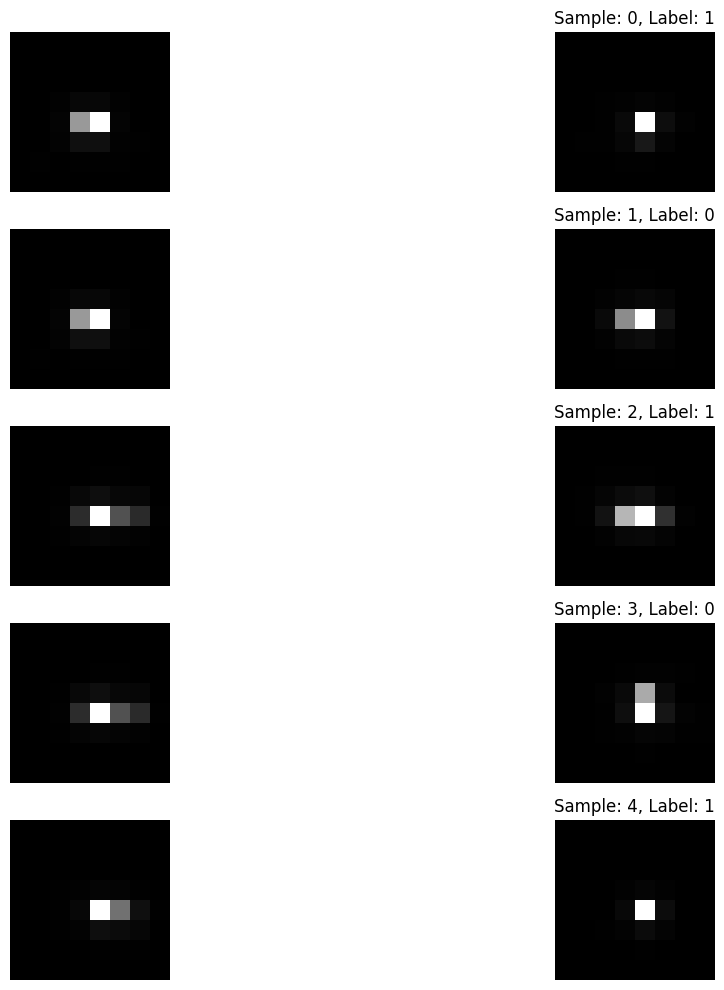

In [4]:
plot_sample_pairs(pairs_train, labels_train, shape=8)

### Defining the Model

In [5]:
# Contrastive loss function based on margin
def contrastive_loss(margin=1.0):
    def loss(y_true, dist):
        y_true = tf.cast(y_true, tf.float32)
        square_dist = tf.square(dist)
        margin_square = tf.square(tf.maximum(margin - dist, 0))
        return tf.reduce_mean(y_true * square_dist + (1 - y_true) * margin_square)
    return loss

In [46]:
# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="ML4Sci-QuantumContrastiveLearning",

    # track hyperparameters and run metadata with wandb.config
    config={
        "input_shape": pairs_train.shape[2:],
        "layer_1": 32,
        "kernel_1": (3,3),
        "activation_1": "relu",
        "mp_kernel": (2,2),
        "layer_2": 64,
        "activation_2": "leaky_relu",
        "regularizer": "l2 0.01",
        "optimizer": "adam",
        "loss": "contrastive_pair_loss",
        "dropout": 0.5,
        "epoch": 50,
        "batch_size": 50000,
        "architecture": "Base CNN",
        "dataset": "electron-photon",
        "clipnorm": False,
    }
)

In [47]:
config = wandb.config

In [48]:
# Define the CNN model 
def create_base_model(input_shape):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(config.layer_1, config.kernel_1, activation=config.activation_1,kernel_initializer=initializers.HeNormal())) 
    model.add(layers.MaxPooling2D(config.mp_kernel))
    model.add(layers.Conv2D(config.layer_2, config.kernel_1, activation=config.activation_1,kernel_regularizer=tf.keras.regularizers.l2(0.01))) 
    model.add(layers.Dropout((config.dropout)))
    model.add(layers.Flatten())
    model.add(layers.Dense(config.layer_2, activation=config.activation_2,kernel_regularizer=tf.keras.regularizers.l2(0.01)))
    return model

In [49]:
# Siamese Network model
def create_siamese_network(input_shape):
    base_model = create_base_model(input_shape)

    input_0 = layers.Input(shape=input_shape)
    input_1 = layers.Input(shape=input_shape)

    processed_0 = base_model(input_0)
    processed_1 = base_model(input_1)

    distance = layers.Lambda(lambda embeddings: tf.sqrt(tf.reduce_sum(tf.square(embeddings[0] - embeddings[1]), axis=-1)), output_shape=(1,)
                            )([processed_0, processed_1])
    
    model = models.Model([input_0, input_1], distance)
    
    return model

In [50]:
# Define the model
import os
checkpoint_path = "../../saved_models/exp1_cnn_base_1_ep/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

input_shape = pairs_train.shape[2:]
siamese_network = create_siamese_network(input_shape)

siamese_network.compile(loss=contrastive_loss(), optimizer=optimizers.Adam(learning_rate=1e-3))

history = siamese_network.fit([pairs_train[:, 0], pairs_train[:, 1]], labels_train,
    validation_data=([pairs_test[:, 0], pairs_test[:, 1]], labels_test),
    epochs=config.epoch,
    batch_size=config.batch_size,
    callbacks=[cp_callback]
)

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 1.3223
Epoch 1: saving model to ../../saved_models/exp1_cnn_base_1_ep\cp.ckpt
16/16 [==============================] - 15s 824ms/step - loss: 1.3223 - val_loss: 1.2518
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 0.9218
Epoch 2: saving model to ../../saved_models/exp1_cnn_base_1_ep\cp.ckpt
16/16 [==============================] - 13s 788ms/step - loss: 0.9218 - val_loss: 1.0426
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 0.7168
Epoch 3: saving model to ../../saved_models/exp1_cnn_base_1_ep\cp.ckpt
16/16 [==============================] - 13s 789ms/step - loss: 0.7168 - val_loss: 0.8785
Epoch 4/50
16/16 [==============================] - ETA: 0s - loss: 0.5862
Epoch 4: saving model to ../../saved_models/exp1_cnn_base_1_ep\cp.ckpt
16/16 [==============================] - 13s 787ms/step - loss: 0.5862 - val_loss: 0.7789
Epoch 5/50
16/16 [==============================] - ETA:

In [51]:
siamese_network.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 8, 8, 1)]            0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 8, 8, 1)]            0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 64)                   22976     ['input_8[0][0]',             
                                                                     'input_9[0][0]']             
                                                                                                  
 lambda_2 (Lambda)           (None,)                      0         ['sequential_2[0][0]',  

<Axes: title={'center': 'Learning History'}>

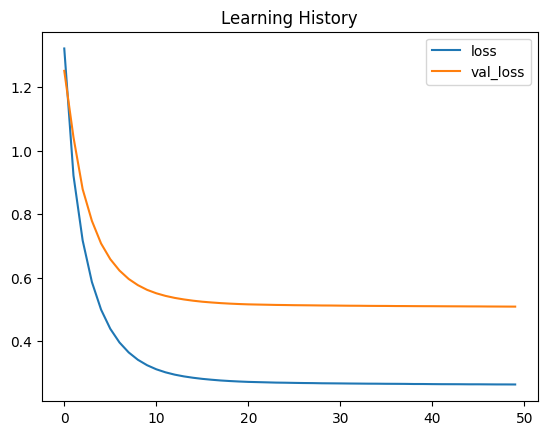

In [52]:
pd.DataFrame(history.history).plot(title="Learning History")

### Evaluation of the model

In [53]:
# Predictions from the model
distance = siamese_network.predict([pairs_test[:, 0], pairs_test[:, 1]])

6225/6225 [==============================] - 28s 4ms/step


In [54]:
distance

array([8.8643283e-04, 5.1073229e-04, 3.6187175e-05, ..., 2.3375833e-06,
       8.0455131e-05, 3.9003426e-05], dtype=float32)

In [55]:
def distances_to_labels(distances, threshold=0.5):
    return (distances <= threshold).astype(int)

In [56]:
y_pred = distances_to_labels(distance)

In [57]:
def plot_samples_with_predictions(test_pairs, test_labels, predictions, distances, size,num_samples=5):
    plt.figure(figsize=(15, num_samples * 2))
    for i in range(num_samples):
        ax = plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(test_pairs[i, 0].reshape(size, size), cmap='gray')
        ax.axis('off')

        ax = plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(test_pairs[i, 1].reshape(size, size), cmap='gray')
        ax.axis('off')

        label = test_labels[i]
        pred = predictions[i]
        dist = distances[i]
        plt.title(f'True: {label}, Pred: {pred}, Dist: {dist:0.15f}')

    plt.tight_layout()
    plt.show()

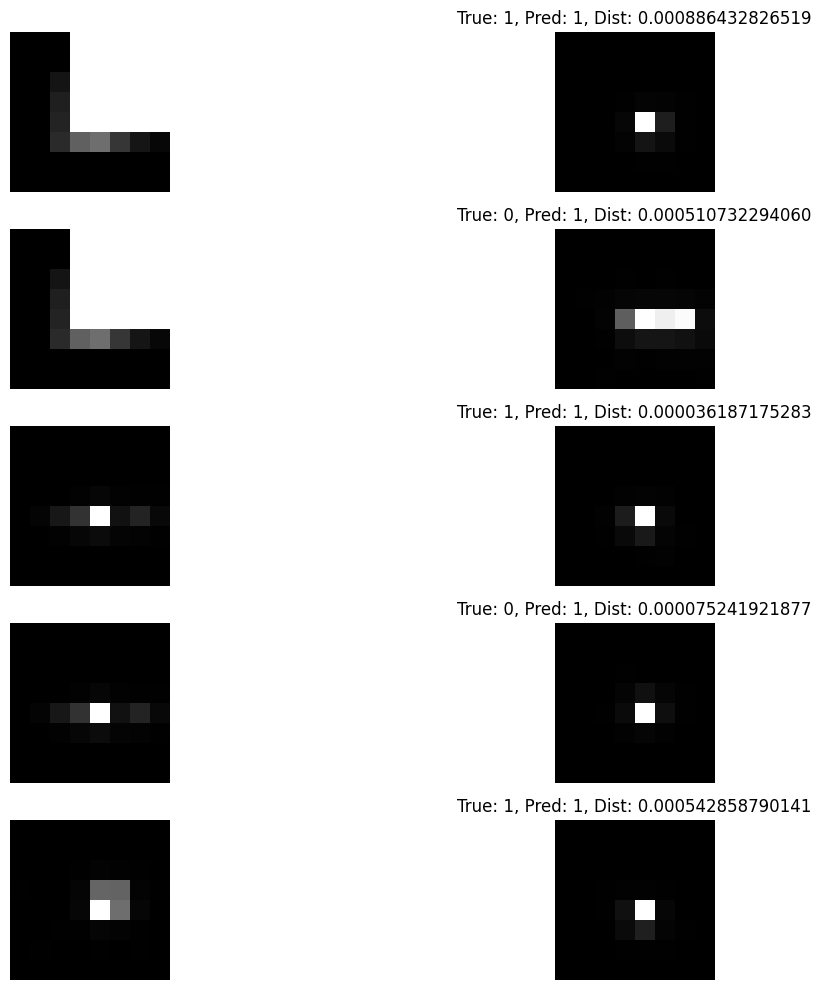

In [58]:
# Plot sample pairs with predictions
plot_samples_with_predictions(pairs_test, labels_test, y_pred, distance, size=8, num_samples=5)

In [64]:
wandb.finish()